In [1]:
# Imports
import urllib
import zipfile

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import HTML, display
from statsmodels.stats.outliers_influence import OLSInfluence

# Functions to remove outliers in continous  designs

# Plotting functions
def hist_no_edge(x, *args, **kwargs):
    """
    Plot a histogram without the left and right edges. Useful for survival curves.
    """
    bins = kwargs.pop("bins")
    cumulative = kwargs.pop("cumulative", False)
    # Add a bin for all p-values between the upper bin and 1.
    cnt, edges = np.histogram(x, bins=bins.tolist() + [1])
    ax = plt.gca()
    if cumulative:
        prop = cnt.cumsum() / cnt.sum()
        ax.step(edges[:-2], prop[:-1], *args, **kwargs)
    else:
        ax.step(edges[:-2], cnt, *args, **kwargs)


def plot_resids_simulation_results(data, include_iterated=True):
    """
    Plot the survival curve of all the simulations.
    """
    gb = data.groupby(["DVType", "IVType", "Level"])  # Data by group.

    # Type I error at various alpha levels
    p_05 = gb["$\\alpha_{{05}}$"].mean()
    p_01 = gb["$\\alpha_{{01}}$"].mean()
    p_001 = gb["$\\alpha_{{001}}$"].mean()

    # Labels for lines and panels
    dvtype_labels = ["Normal", "Log-Normal", "Normal Mixture"]
    ivtype_labels = ["Continuous", "Categorical"]

    levels = ["None", "Predictor-Blind", "Predictor-Aware"]
    labels = ["None", "Predictor-Blind", "Predictor-Aware"]
    maxcoord = 3

    ycoords = 0.65 + np.arange(0, 1, 0.06)  # Coordinates to plot legend

    pal = sns.color_palette()[0:4]  # Colors

    # Initialize the plot
    g = sns.FacetGrid(
        data,
        col="DVType",
        row="IVType",
        hue="Level",
        hue_order=levels,
        col_order=dvtype_labels,
        row_order=ivtype_labels,
        height=3.4,
        aspect=1.2,
        sharey=True,
        sharex=True,
        hue_kws=dict(ls=[(0, ()), (1, (5, 5)), (0, ()), (1, ())]),
    )

    # Map the survival curve to each panel and color
    g.map(
        hist_no_edge,
        "pvalue",
        cumulative=True,
        bins=np.logspace(np.log10(10e-40), np.log10(0.05), 10000),
        lw=1.5,
    )

    # Change the axes labels
    g.set_ylabels("Fraction of Sig. Tests ($p < \\alpha$)")
    g.set_xlabels("Sig. Threshold ($\\alpha$)")
    g.set_titles("{col_name} Data, {row_name} IV")

    # Adjust the axes and ticks
    for i, (axe, ivtyp) in enumerate(zip(g.axes, ivtype_labels)):
        for j, (ax, dvtyp) in enumerate(zip(axe, dvtype_labels)):
            ax.set_xlim(10e-8, 0.05)
            ax.set_xscale("log")
            ax.set_xticks([10e-8, 10e-7, 10e-6, 10e-5, 10e-4, 10e-3, 0.05])
            ax.set_xticklabels(
                ["10e-8", "10e-7", ".00001", ".0001", ".001", ".01", ".05"]
            )
            ax.set_xticks([], minor=True)
            ax.invert_xaxis()
            ax.annotate(
                f"Type I Error Rate at $[\\alpha_{{05}}, \\alpha_{{01}}, \\alpha_{{001}}]$",
                (1, ycoords[maxcoord]),
                color="black",
                fontsize=10,
                ha="right",
                xycoords="axes fraction",
            )
            _, yh = ax.get_ylim()
            ys = np.round(yh / 6, 2)
            ax.set_yticks(np.arange(0, yh, ys))
            # Add the false-positive annotations
            for k, (lab, lev) in enumerate(zip(labels, levels)):
                ax.annotate(
                    f"{lab}: [{p_05.loc[dvtyp, ivtyp, lev]:.2f}, "
                    f" {p_01.loc[dvtyp, ivtyp, lev]:.2f}, "
                    f"{p_001.loc[dvtyp, ivtyp, lev]:.3f}]",
                    (1, ycoords[k]),
                    color=pal[k],
                    ha="right",
                    xycoords="axes fraction",
                    fontsize=10,
                )


# Functions to remove residual-based outliers
def remove_residuals_blind(y, X, cutoff_thresh=2):
    """
    Remove outliers from residuals of model that is blind to the key predictor X.
    """
    model = sm.OLS(y, X[:, 1:])
    results = model.fit()
    resids = OLSInfluence(results).resid_studentized_internal
    return (
        y[(resids >= -cutoff_thresh) & (resids <= cutoff_thresh)],
        X[(resids >= -cutoff_thresh) & (resids <= cutoff_thresh), :],
    )


def remove_residuals_aware(y, X, cutoff_thresh=2):
    """
    Remove outliers from residuals of model that is aware of the key predictor X.
    """
    model = sm.OLS(y, X)
    results = model.fit()
    resids = OLSInfluence(results).resid_studentized_internal
    return (
        y[(resids >= -cutoff_thresh) & (resids <= cutoff_thresh)],
        X[(resids >= -cutoff_thresh) & (resids <= cutoff_thresh), :],
    )


def compare_pvals_under_resid_exclusions(y, X, cutoff_thresh=2):
    """
    Compare p-values from OLS model when (1) No outliers are excluded, (2) Outliers
    are excluded based the hypothesis-blind residuals,
    (3) Outliers excluded based the hypothesis-aware residuals
    """
    y_blind, X_blind = remove_residuals_blind(y, X, cutoff_thresh=cutoff_thresh)
    y_aware, X_aware = remove_residuals_aware(y, X, cutoff_thresh=cutoff_thresh)
    pvals_base = sm.OLS(y, X).fit().pvalues[0]
    pvals_blind = sm.OLS(y_blind, X_blind).fit().pvalues[0]
    pvals_aware = sm.OLS(y_aware, X_aware).fit().pvalues[0]
    return pvals_base, pvals_blind, pvals_aware


def mixturesampler(size):
    """
    Return a mixture of two normal distribution: The value is sampled from N(0, 1) with p = .95,
    and with N(5, 1) with p= .05, such that 5% of observations are outliers.
    """
    low = np.random.normal(0, 1, size)
    high = np.random.normal(5, 1, size)
    mixture = np.random.choice([0, 1], p=[0.95, 0.05], size=size)
    return low + high * mixture

<br/>

In the [first part of this blog post](https://quentinandre.net/post/dealing-with-outliers-part-one/), I examined the impact of excluding outliers by condition (rather than across the data), and showed that this practice can increase Type I error rates to unacceptable levels.

In this second part, I demonstrate a more general result [from the paper](https://quentinandre.net/publication/outliers-blind-hypothesis/): Any outlier exclusion procedure that is not blind to the hypothesis that researchers want to test may result in inflated false-positive rates.

## Residual-Based Methods for Excluding Outliers

In the previous blog post, I examined three common methods for identifying and excluding outliers:
* The IQR method (used for instance in boxplots)
* The z-score
* The Median Absolute Difference (MAD)

These methods are most commonly encountered in the context of simple between-subject designs.

In the context of more complex designs (e.g., models involving interactions, continuous predictors, repeated measures…), a general approach to identifying and excluding outliers is to use the standardized (or studentized) residuals obtained from a linear model. With this approach, any data point with a residual greater than some pre-determined threshold is excluded from the data.

## Hypothesis-Blind vs. Hypothesis-Aware Exclusions

An important subtlety of residuals-based exclusion procedures is often overlooked: The model from which the residuals are computed must be blind to the hypothesis of interest.

To understand the difference, consider the following example: A researcher wants to test if a variable X is associated with an outcome Y. The model testing this hypothesis is $Y_i = \alpha + \beta X_i + \epsilon_i$, and the researcher's null hypothesis is $\beta = 0$.

The researcher is concerned about outliers, and will exclude any data point with standardized residuals greater than 2. However, there are two different models from which the standardized residuals can be computed:
* An "hypothesis-aware" model, that includes the predictor of interest: $Y_i = \alpha + \beta X_i + \epsilon_i$
* An "hypothesis-blind" model, that excludes the predictor of interest: $Y_i = \alpha + \epsilon_i$

The choice of computing residuals in one way or another is again very consequential. Consider the data below: The null hypothesis is true, so we should observe no significant relationship between X and Y.

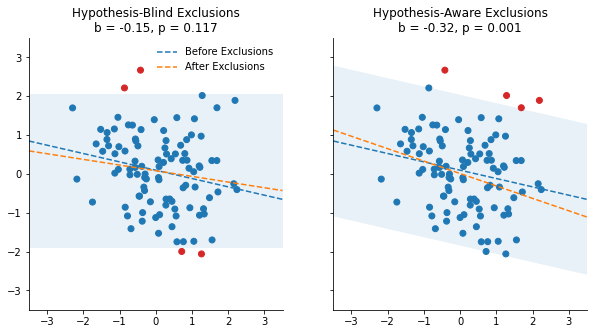

In [2]:
# Simulating an experiment
np.random.seed(2387921)
pbase, pblind, paware = 0.001, 0.001, 0.001
n = 100
intercept = np.ones(n)
blue, orange, _, red, *_ = sns.color_palette()
while (paware > 0.001) | (pblind < 0.1):  # Cherry-picking an illustrative example
    y = np.random.normal(size=n)  # Vector of DV
    x = np.random.normal(size=n)  # Vector of IV, that has no influence on Y.
    X = np.vstack([x, intercept]).T
    pbase, pblind, paware = compare_pvals_under_resid_exclusions(y, X)

# Recovering parameters for plotting
y_blind, X_blind = remove_residuals_blind(y, X, cutoff_thresh=2)
x_blind = X_blind[:, 0]
y_aware, X_aware = remove_residuals_aware(y, X, cutoff_thresh=2)
x_aware = X_aware[:, 0]

model_blind = sm.OLS(y, X[:, 1:]).fit()
model_aware = sm.OLS(y, X).fit()

model_blind_excl = sm.OLS(y_blind, X_blind).fit()
model_aware_excl = sm.OLS(y_aware, X_aware).fit()

resids_blind = OLSInfluence(model_blind).resid_studentized_internal
resids_aware = OLSInfluence(model_aware).resid_studentized_internal
std_resid_blind = OLSInfluence(model_blind).resid.std()
std_resid_aware = OLSInfluence(model_aware).resid.std()

xpos = np.linspace(-3.5, 3.5, 100)
ypred_base = model_aware.params[0] * xpos + model_aware.params[1]
ypred_blind = model_blind_excl.params[0] * xpos + model_blind_excl.params[1]
ypred_aware = model_aware_excl.params[0] * xpos + model_aware_excl.params[1]

ci_blind = (
    np.tile(model_blind.params[0], n) + 2 * std_resid_blind,
    np.repeat(model_blind.params[0], n) - 2 * std_resid_blind,
)
ci_aware = (
    model_aware.params[1] + xpos * model_aware.params[0] + 2 * std_resid_aware,
    model_aware.params[1] + xpos * model_aware.params[0] - 2 * std_resid_aware,
)

# Plotting

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
axes[0].scatter(x, y, c=[red if np.abs(v) > 2 else blue for v in resids_blind])
axes[0].plot(xpos, ypred_base, ls="--", label="Before Exclusions")
axes[0].plot(xpos, ypred_blind, ls="--", label="After Exclusions")
axes[0].fill_between(xpos, *ci_blind, alpha=0.1)
axes[0].set_title(
    f"Hypothesis-Blind Exclusions\nb = {model_blind_excl.params[0]:.2f}, p = {pblind:.3f}"
)
axes[0].legend(frameon=False)
axes[1].plot(xpos, ypred_base, ls="--")
axes[1].plot(xpos, ypred_aware, ls="--")
axes[1].fill_between(xpos, *ci_aware, alpha=0.1)
axes[1].scatter(x, y, c=[red if np.abs(v) > 2 else blue for v in resids_aware])
axes[1].set_title(
    f"Hypothesis-Aware Exclusions\nb = {model_aware_excl.params[0]:.2f}, p = {paware:.3f}"
)
for ax in axes:
    ax.set_xlim(-3.5, 3.5)
    ax.set_ylim(-3.5, 3.5)
sns.despine()
fig = plt.gcf()
plt.close()
display(fig, metadata=dict(filename="Fig1"))

In these figures, any observation outside of the pale blue area has standardized residuals greater than 2, and is considered an outlier (red dots). The two panels differ in how this critical area is calculated:
* In the left panel, this area is based on the hypothesis-blind model: It only considers the intercept $\alpha$, and omits the predictor of interest $X$.
* In the right panel, this area is based on the hypothesis-aware model, and therefore also considers the value of $X$.

The dashed lines displays the regression coefficient of X before (in blue) and after (orange) excluding the outliers. We show that the slope is not significant (p = .117) in the left panel, and very significant (p = .001) in the right panel. How did this happen?

Since the "hypothesis-aware" procedure takes into account the value of X, it **amplifies** the coincidental negative relationship observed between X and Y, and make it very significant.

Look at the three observations in the upper-right corner for instance. In the hypothesis-blind procedure, they are not flagged as outliers, because those values are not sufficiently far from what the intercept would predict. In contrast, they are flagged as outliers by the hypothesis-aware procedure because they are higher than what *the negative slope of X would predict*. But here, this slope is accidental, and using it as a criteria to exclude outliers leads to a false-positive.

## Hypothesis-Aware Exclusions Increase False-Positive Rates

Again, this figure is only an illustration of a general problem. To show the impact of "hypothesis-aware" exclusions, I simulated a large number of "experiments" conducted over each of 18 possible datasets, orthogonally varying the type of predictor X (continuous vs. discrete), the sample size (N = 50, 100, or 250) and the error structure of the data (normal, log-normal, or normal with outliers).

The full breakdown of results is available on the OSF repository of the paper, but here is an overview again:

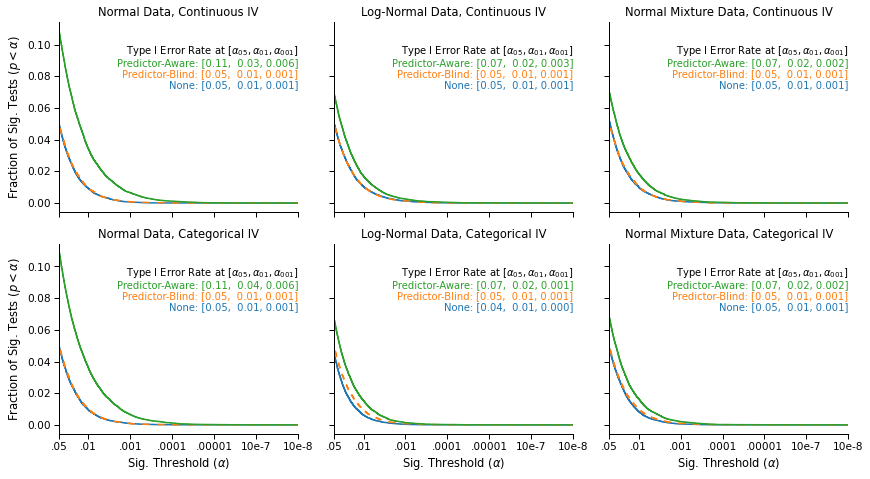

In [3]:
if "df_pvals" not in locals():  # See if the simulations are loaded in memory
    try:  # If not, see if the simulations have been downloaded.
        df_pvals_resid = pd.read_csv("Buffer/Buffered_pvals_resid.csv")
    except:  # Otherwise download them from OSF repository.
        url = "https://osf.io/46bxa/download"
        urllib.request.urlretrieve(url, "Buffer/buffered_pvals.zip")
        with zipfile.ZipFile("Buffer/buffered_pvals.zip", "r") as zip_ref:
            zip_ref.extractall("Buffer")
        df_pvals_resid = pd.read_csv("Buffer/Buffered_pvals_resid.csv")
with sns.plotting_context("paper", font_scale=1.2):
    # Plot the simulation results
    plot_resids_simulation_results(df_pvals_resid)
    plt.tight_layout()
fig = plt.gcf()
plt.close()
display(fig, metadata=dict(filename="Fig2"))

This figure again displays the survival curves of the tests: The fraction of tests that were significant (on the y-axis) at a given significance threshold (on the x-axis), under different outlier exclusion cutoffs (panels) and different outlier exclusion strategies (lines).

We see that when no outliers are excluded (blue), or when the outliers are excluded using hypothesis-blind residuals (orange, on top of the blue line), the false-positive rates that we observe are nominal: 5% of tests are significant at α = .05,  1% are significant at α = .01, and .1% are significant at α = .001.

In contrast, we again observe an increase in false-positive rates when using hypothesis-aware residuals (green line).

In sum, when excluding outliers, make sure to do it in a way that is blind to the hypothesis that you have to test:
* If you have experimental conditions, apply the procedure across the data (rather than within-conditions)
* If you are using residual-based methods, compute the residuals using a model that does not include your predictor of interest.